root mean squared error = 1.42546810271799
root mean squared error = 1.4372115060100445
root mean squared error = 1.4235326121107466
root mean squared error = 1.4192025120327854
root mean squared error = 1.4243339973355145
root mean squared error = 1.4191067066340588
root mean squared error = 1.4246518854623114
root mean squared error = 1.433292647449805
root mean squared error = 1.4166308644955734
root mean squared error = 1.4373431347986392
root mean squared error = 1.4308574692675007
root mean squared error = 1.440334811022058
root mean squared error = 1.4220925520712246
root mean squared error = 1.437775168170913
root mean squared error = 1.4235410021036747
root mean squared error = 1.4159226918524566
root mean squared error = 1.4100082725069558
root mean squared error = 1.4120581179923648
root mean squared error = 1.4380521063669487
root mean squared error = 1.4462892336889581
root mean squared error = 1.428607191962204
root mean squared error = 1.4369655506456904
root mean square

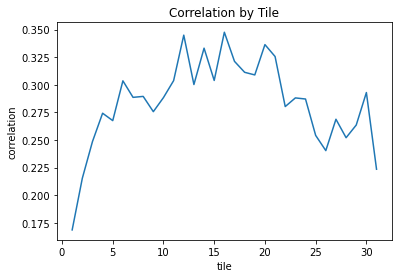

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
import joblib
import sys

#chr8,chr18 as test set
def sequence_file(tile_num):
    #create datapaths 
    Data_path = "/u/home/m/mardren/scratch/SequenceML"
    gkm_path = "%s/features.gkSVM.HepG2.tsv.gz"%Data_path
    conv_path       = "%s/features.dragoNN_ConvModel.HepG2.SV40P.Rep1.tsv.gz"%Data_path
    deepfact_path       = "%s/features.dragoNN_DeepFactorizedModel.HepG2.SV40P.Rep1.tsv.gz"%Data_path
    #this is the label, sorry kind of confusingly named
    sharpr_path = "%s/6mer_sharpr_score_tile_evenchrtesting.pkl"%Data_path


    #open data from csv into dataframes
    gkm = pd.read_csv(gkm_path, header = 0, index_col = 0, sep = '\t')
    conv  = pd.read_csv(conv_path, header = 0, index_col = 0, sep = '\t')
    deepfact = pd.read_csv(deepfact_path, header = 0, index_col = 0, sep = '\t')
    #subset by selected tile
    sharpr = pd.read_pickle('%s'%(sharpr_path))
    gkm_15 = gkm[['feat_gksvm_%s'%tile_num]]
    gkm_15 = gkm_15.rename(columns = {'feat_gksvm_%s'%tile_num:'gkm_%s'%tile_num})
    conv_15 = conv[[tile_num]]
    conv_15 = conv_15.rename(columns = {tile_num:'conv_%s'%tile_num})
    deepfact_15 = deepfact[[tile_num]]
    deepfact_15 = deepfact_15.rename(columns = {tile_num:'deepfact_%s'%tile_num})
    tile_num = int(tile_num)
    sharpr_15 = sharpr[[tile_num]]
    sharpr_15 = sharpr_15.rename(columns = {tile_num:'sharpr_%s'%tile_num})

    #create data dataframe
    data = pd.concat([conv_15,gkm_15,deepfact_15, sharpr_15], axis=1)
    



    #reset index to be able to access region_id
    data = data.reset_index()

    #split region_id to create chrom column
    data['chrom'] = data['region_id'].str.split('_').str[3]

    #splitting training testing data
    #     train_chroms = [f'chr{i}' for i in range(1,23,2)]
    #     test_chroms = [f'chr{i}' for i in range(2,23,2)]
    #     chrX = data[data["chrom"]==('chrX')]
    #     test_set = data[data["chrom"].isin(test_chroms)]
    #     train_set = data[data["chrom"].isin(train_chroms)]
    #     train_set = train_set.append(chrX)
    test_set_8 = data[data["chrom"] == ('chr8')]
    test_set_18 = data[data["chrom"] ==('chr18')]
    test_set = pd.concat([test_set_8,test_set_18],axis=0)
    train_set = data[data["chrom"] != ('chr8')]
    train_set = train_set[train_set["chrom"] != ('chr18')]

    #drop chrom column
    test_set = test_set.drop(columns=['chrom'])
    train_set = train_set.drop(columns=['chrom'])
    data = data.drop(columns=['chrom'])

    #seperate region_id column to combine at the end
    test_regionid = test_set['region_id']
    test_regionid = pd.DataFrame(test_regionid)
    test_regionid = test_regionid.reset_index(drop=True)
    test_regionid = test_regionid.sort_values(by=['region_id'])

    #check correlation if you want
#     sharpr_15_array = np.asarray(test_set['sharpr_15'])
#     sharpr_15_array = sharpr_15_array.flatten()
#     conv_15_array = np.asarray(conv_15)
#     conv_15_array = conv_15_array.flatten()
#     deepfact_15_array = np.asarray(deepfact_15)
#     deepfact_15_array = deepfact_15_array.flatten()
#     gkm_15_array = np.asarray(gkm_15)
#     gkm_15_array = gkm_15_array.flatten()
#     print('corr of Normalized (RNA/DNA) and dragoNN ConvModel:')
#     print(pd.Series(sharpr_15_array).corr(pd.Series(conv_15_array),method='spearman'))
#     print('corr of Normalized (RNA/DNA) and gkmSVMModel:')
#     print(pd.Series(sharpr_15_array).corr(pd.Series(gkm_15_array),method='spearman'))
#     print('corr of Normalized (RNA/DNA) and dragoNN DeepFactorizedModel:')
#     print(pd.Series(sharpr_15_array).corr(pd.Series(deepfact_15_array),method='spearman'))

    
    #format training data
    labels = train_set['sharpr_%s'%tile_num].values
    train_set = train_set.drop(columns=['region_id','sharpr_%s'%tile_num])
    encodings = train_set.values.tolist()
    encodings = np.asarray(encodings)
    encodings_df = pd.DataFrame(encodings)
    encodings_df.fillna(encodings_df.mean(), inplace=True)
    encodings = encodings_df.to_numpy()
    labels = np.reshape(labels,(14753 ,))

    #format the testing data
    test_labels = test_set['sharpr_%s'%tile_num].values
    test_set = test_set.drop(columns=['region_id','sharpr_%s'%tile_num])
    test_encodings = test_set.values.tolist()
    test_encodings = np.asarray(test_encodings)
    test_encodings_df = pd.DataFrame(test_encodings)
    test_encodings_df.fillna(test_encodings_df.mean(), inplace=True)
    test_encodings = test_encodings_df.to_numpy()
    test_labels = np.reshape(test_labels,(967 ,))


    #format data
    data_labels = data['sharpr_%s'%tile_num].values
    data = data.drop(columns=['region_id','sharpr_%s'%tile_num])
    data_encodings = data.values.tolist()
    data_encodings = np.asarray(data_encodings)
    data_encodings_df = pd.DataFrame(data_encodings)
    data_encodings_df.fillna(data_encodings_df.mean(), inplace=True)
    data_encodings = data_encodings_df.to_numpy()
    data_labels = np.reshape(data_labels,(15720,))

    #train a linear regressor on the training dataset. 
    from sklearn.linear_model import LinearRegression

    sequence_regressor = LinearRegression()
    sequence_regressor.fit(encodings, labels)

    #compute mse
    from sklearn.metrics import mean_squared_error
    train_predictions = sequence_regressor.predict(encodings)
    train_mse = mean_squared_error(train_predictions, labels)
    train_rmse = np.sqrt(train_mse)
    print("root mean squared error = %s"%train_rmse)

    test_predictions = sequence_regressor.predict(test_encodings)
    test_mse = mean_squared_error(test_predictions, test_labels)
    test_rmse = np.sqrt(test_mse)
    



    #visualize the results
    corr = pd.Series(test_predictions).corr(pd.Series(test_labels))

    caption = "correlation pearson r= %s"%(corr)
    rmse = "root mean squared error = %s"%test_rmse




#     plt.scatter(
#         x=test_predictions,
#         y=test_labels,
#         edgecolors='w'
#     )
#     tile_num = int(tile_num)
#     tile_num = tile_num + 1

#     plt.title("Tile %s Sequence Regressor on chr8,chr18 Test Set"%(tile_num))
#     plt.xlabel("test_predictions \n\n %s \n\n %s"%(caption,rmse))
#     plt.ylabel("test_labels")

#     plt.savefig("sequence_predictions_tile%s"%tile_num)

#     print("Regressor coefficients(ConvModel,gkmSVMModel,DeepFactorizedModel):")
#     print(sequence_regressor.coef_)

    #format data
    test_predictions = pd.DataFrame(test_predictions)
    test_predictions = pd.concat([test_predictions,test_regionid], axis=1)
    test_predictions = test_predictions.set_index('region_id')
    test_labels = pd.DataFrame(test_labels)
    test_labels = pd.concat([test_labels,test_regionid], axis=1)
    test_labels = test_labels.set_index('region_id')
    return test_predictions





if __name__ == "__main__":
# take tile_num in as a parameter
#     sequence_file('14')


    predictions_df = pd.DataFrame()
    for tile in range(31):
        tile_num = str(tile)
        tile_df = sequence_file(tile_num)
        tile_num = int(tile_num)
        real_tile_num = tile_num+1
        tile_df = tile_df.rename(columns={0:real_tile_num})
        predictions_df = pd.concat([predictions_df,tile_df], axis=1)
        

    
